# Entrenar un robot utilizant Q-Learning

## Introducció

En aquest notebook, entrenarem un robot perquè trobi la millor ruta per arribar a la seva destinació. Utilitzarem algorsimes genètics per aconseguir-ho. 

Com ja hem vist en altres notebooks, els algoritmes genètics són una tècnica d'optimització inspirada en la selecció natural. En aquest cas, l'objectiu és trobar la millor ruta per arribar a la destinació. Partirem d'una xarxa neuronal ja creada i anirem modificant els pesos per aconseguir la millor ruta.

## Preparar les llibreries

Utilitzarem les llibreries d'`aitk` per aconseguir el nostre objectiu. Començarem instal·lant les llibreries necessàries.

In [1]:
!pip install aitk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from aitk.algorithms.ga import GeneticAlgorithm
from aitk.networks import SimpleNetwork
import aitk.robots as bots
from aitk.robots.utils import distance
from aitk.utils import Grid

import numpy as np

import random

## Algorisme genètic

En aquest problema plantejarem les següents definicions:

- **Gen**: Un gen serà un pes de la xarxa neuronal.
- **Cromosoma**: Un cromosoma serà una xarxa neuronal amb els pesos corresponents. El seu tamany serà el nombre de pesos de la xarxa neuronal.
- **Població**: Una població serà un conjunt de cromosomes.

El mon i el robot seran els mateixos que en el notebook anterior.

Per definir l'algorisme genètic utilitzarem la classe `GeneticAlgorithm` de la llibreria `aitk.algorithms.ga`. Aquesta classe necessita facilita la creació de l'algorisme.

In [3]:
class RobotAG(GeneticAlgorithm):
    def __init__(self, tamany_poblacio):
        self.world = bots.World(240, 150)

        self.world.add_wall("blue", 0, 0, 50, 50)
        self.world.add_wall("blue", 75, 200, 125, 150)
        self.world.add_wall("blue", 150, 0, 200, 50)
        self.world.add_wall("blue", 150, 150, 200, 100)
        self.world.add_wall("blue", 0, 100, 50, 150)

        self.world.add_wall("blue", 100, 25, 105, 125)
        self.world.add_wall("blue", 100, 70, 120, 75)

        self.world.add_bulb("yellow", 125, 130, 1, 30)

        self.robot = bots.Scribbler(x=30, y=80, a=90)
        self.robot.add_device(bots.RangeSensor(width=45,max=20,name="front"))
        self.robot.add_device(bots.RangeSensor(width=45,max=20,position=(6,-6),
                                                a=90,name="left"))
        self.robot.add_device(bots.LightSensor(position=(6, 0), name="light"))

        self.world.add_robot(self.robot)

        self.pos_inicial = (30, 80, 90)

        self.net = SimpleNetwork(3, 5, 2, activation="tanh", optimizer="adam", loss="mse")

        tamany_cromosoma = len(self.net.get_weights(flat=True))

        super().__init__(length=tamany_cromosoma, popSize=tamany_poblacio)

    def make_random_gene(self):
        # Retorna un valor aleatori per a un pes de la xarxa (entre -2 i 2)

        return random.uniform(-2, 2)
    
    def mutate_gene(self, gen):
        # Muta un gen canviant-lo lleugerament

        return gen + random.uniform(-0.5, 0.5)
    
    def fitness(self, chromosome, index=None, poses=None, seconds=180, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        # Avalua el cromosoma i retorna el seu valor de fitness

        # Tornem a posar el robot a la posició inicial
        self.world.reset()
        self.robot.set_pose(*self.pos_inicial)
        self.grid = Grid((10, 10), self.world)

        # Establim els pesos de la xarxa
        self.net.set_weights(chromosome)

        # Executem el robot durant 100 segons màxim
        self.world.seconds(
            seconds, self.controller,
            real_time=real_time
        )

        # Calculem el valor de fitness
        score = 0

        if not self.robot.stalled:
            visites = self.grid.analyze_visits()
            sensor_lum = self.robot["light"]
            llum = sensor_lum.get_brightness()

            # Volem que el robot s'aproximi a la llum en els mínims passos possibles
            # Per aixó el valor de fitness serà 1/la distancia a la llum - el temps que ha trigat (escalat  )

            pos_actual = self.robot.get_pose()
            x_actual, y_actual = pos_actual[0], pos_actual[1]

            score = visites * 10 + llum * 100 - self.world.time / 2000
            
        return score

    def controller(self, world):
        # Controlador del robot

        sensor_esquerra = self.robot["left"]
        sensor_davant = self.robot["front"]
        sensor_lum = self.robot["light"]

        dist_esq = sensor_esquerra.get_distance()
        dist_davant = sensor_davant.get_distance()
        llum = sensor_lum.get_brightness()

        inputs = np.array([dist_esq/20, dist_davant/20, llum])
        output = self.net.predict(np.array([inputs]))
        
        out = output[0]

        x, y, a = self.robot.get_pose()
        self.grid.update(x, y)
        self.grid.draw()

        if inputs[-1] > 0.95:
            return True
        else:
            self.robot.move(out[0], out[1])
        
        if self.robot.stalled:
            return True

ag = RobotAG(10)

Random seed set to: 1509598


2024-12-11 20:44:52.033633: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 20:44:52.434078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 20:44:52.434143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 20:44:52.461109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 20:44:52.517573: I tensorflow/core/platform/cpu_feature_guar

Genetic algorithm
  Chromosome length: 32
  Population size: 10


In [4]:
ag.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [5]:
ag.fitness(ag.make_random_chromosome())


Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 46.05 x real time


0.21

In [6]:
%%time
ag.reset()
ag.world.reset()
ag.world.time = 0
bestFound = ag.evolve(
    generations=20, 
    crossover_rate=0.2, 
    mutation_rate=0.6, 
    elite_percent=0.05, 
    seconds=180,
    show=True,
) 

Using random seed: 1509598
Maximum number of generations: 20
  Elite percentage 0.05 (0/10 chromosomes per generation)
  Crossover rate: 0.2 (~2/10 crossovers per generation)
  Mutation rate: 0.6 (~384/320 genes per generation)
Evaluating initial population...
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 31.82 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 46.58 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.10; speed 28.6 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.90; speed 35.52 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 47.14 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 30.48 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.02 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.75 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.86 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.84 x real time
Done!


  0%|          | 0/20 [00:00<?, ?it/s]

Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.66 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.47 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.94 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.51 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.79 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.92 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:23.80; speed 45.91 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.19 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.95 x real time
Generation    1 Best fitness 0.31
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.10; speed 27.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:25.60; speed 52.16 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.60; speed 36.46 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.71 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.02 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.58 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 41.74 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 37.06 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 37.43 x real time
Generation    2 Best fitness 0.31
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 33.54 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.67 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.16 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.99 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.63 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.10; speed 34.61 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.29 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 32.99 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.60; speed 40.59 x real time
Generation    3 Best fitness 0.31
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 44.33 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.73 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.11 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:29.50; speed 45.85 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.37 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.66 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 27.88 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.0 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 34.75 x real time
Generation    4 Best fitness 0.31
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.14 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.9 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 47.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.50; speed 35.7 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 43.46 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 37.79 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 45.92 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.94 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 39.61 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 45.25 x real time
Generation    5 Best fitness 0.31
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 29.01 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.27 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.11 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.26 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.27 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.32 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.81 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:32.30; speed 59.21 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.18 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.40; speed 28.77 x real time
Generation    6 Best fitness 0.61
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.30; speed 25.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.37 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.0 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.02 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 57.39 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.74 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.18 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 64.51 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.43 x real time
Generation    7 Best fitness 0.81
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 59.58 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.27 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 57.65 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.68 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.49 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.17 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.84 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.34 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.83 x real time
Generation    8 Best fitness 0.81
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 52.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.05 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.48 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 60.81 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.30; speed 45.77 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.0 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 60.75 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.20; speed 63.05 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 58.01 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.56 x real time
Generation    9 Best fitness 0.81
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.4 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.83 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.4 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.14 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.62 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.08 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.10; speed 48.46 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.57 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.90; speed 53.23 x real time
Generation   10 Best fitness 0.81
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:55.70; speed 56.9 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.55 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 34.49 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.93 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.55 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.46 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.2 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 47.38 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.9 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.25 x real time
Generation   11 Best fitness 0.91
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.64 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.34 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 57.39 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.94 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.36 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.36 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 50.16 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 37.79 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.6 x real time
Generation   12 Best fitness 0.91
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.51 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.42 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 44.46 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.63 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.4 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.23 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.11 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 51.69 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.76 x real time
Generation   13 Best fitness 1.11
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 33.6 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.11 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 54.45 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.87 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.07 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:38.90; speed 45.54 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 54.93 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 55.14 x real time
Generation   14 Best fitness 1.11
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 46.86 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.69 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 39.39 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.06 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.85 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.32 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.63 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.88 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.34 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.70; speed 56.93 x real time
Generation   15 Best fitness 1.11
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.75 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 57.97 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 49.6 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.1 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.93 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.69 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.56 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.64 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.81 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.39 x real time
Generation   16 Best fitness 13.00
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.96 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 52.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.16 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 60.27 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.5 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 55.76 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.22 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 59.57 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.37 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.10; speed 65.26 x real time
Generation   17 Best fitness 13.00
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 56.83 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 58.1 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 48.51 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 50.02 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 53.11 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 44.16 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 60.21 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 64.5 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:23.30; speed 50.75 x real time
Generation   18 Best fitness 13.00
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 64.88 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.77 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.90; speed 53.49 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 65.13 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.74 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.59 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.66 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 61.36 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 52.12 x real time
Generation   19 Best fitness 13.00
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.98 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 64.28 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.17 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 64.38 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 65.0 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 64.53 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.93 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 63.75 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 62.07 x real time
Using random seed: 1509598


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 65.09 x real time
Generation   20 Best fitness 13.00
Max generations reached
CPU times: user 9min 8s, sys: 4.16 s, total: 9min 12s
Wall time: 9min 8s


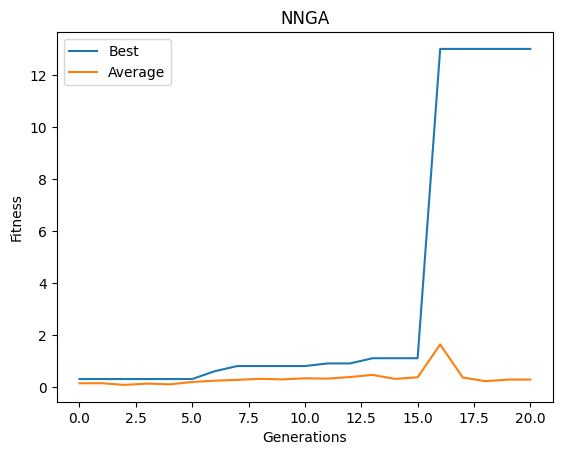

In [7]:
ag.plot_stats("NNGA")

In [8]:
ag.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [9]:
ag.fitness(
    ag.bestEver, 
    real_time=False, 
    show=True, 
    seconds=360,
)

Using random seed: 1509598


  0%|          | 0/3600 [00:00<?, ?it/s]

Simulation stopped at: 00:06:00.00; speed 50.71 x real time


16.421100473538846